In [551]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from sklearn import covariance
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
import networkx as nx
from exchange.ftx.client import FtxClient

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

client = FtxClient()


#### Get Data

In [552]:
# Training
formation_start_date = datetime.fromisoformat('2021-07-01 00:00:00+00:00')
formation_end_date = datetime.fromisoformat('2021-09-01 00:00:00+00:00')
minimum_volume = 5000000
resolution = '15m'
futures = client.get_futures()
perps = []
for future in futures:
    if 'PERP' in future['name'] and future['volumeUsd24h'] > minimum_volume:
        perps.append(future['name'])

ohlc = {}
prices = {}
for perp in perps:
    data = []
    try:
        data = pd.read_parquet('/Users/walidmadaoui/Desktop/ARB/data/{}_{}.parquet.gzip'.format(perp, resolution))
    except:
        print('Cannot find {} data'.format(perp))
    
    if len(data) > 0:
        data['startTime'] = data['startTime'].apply(lambda x: datetime.fromisoformat(x))
        ohlc[perp] = data.set_index('startTime')
        prices[perp] = ohlc[perp]['close']

formation_prices_df = pd.DataFrame(prices)[formation_start_date:formation_end_date].T.dropna().T
formation_prices_df

Cannot find OP-PERP data


,1INCH-PERP,AAVE-PERP,ADA-PERP,ALGO-PERP,ALT-PERP,AR-PERP,ATOM-PERP,AVAX-PERP,AXS-PERP,BCH-PERP,...,VET-PERP,WAVES-PERP,XLM-PERP,XMR-PERP,XRP-PERP,XTZ-PERP,YFI-PERP,YFII-PERP,ZEC-PERP,ZIL-PERP
startTime,,,,,,,,,,,,,,,,,,,,,
2021-07-01 00:00:00+00:00,2.4945,247.80,1.369315,0.8731,3293.55,10.200,11.8695,11.812,5.708,520.30,...,0.089115,16.0020,0.277925,218.91,0.694750,3.0274,33600.0,1950.50,129.22,0.08626
2021-07-01 00:15:00+00:00,2.4969,247.73,1.370415,0.8720,3295.95,10.236,11.8140,11.836,5.618,520.00,...,0.090085,15.8915,0.278275,218.92,0.693250,3.0183,33625.0,1946.75,128.81,0.08600
2021-07-01 00:30:00+00:00,2.4931,247.56,1.366110,0.8725,3296.10,10.265,11.7845,11.849,5.565,520.50,...,0.089975,15.8085,0.278750,218.79,0.692350,3.0218,33655.0,1945.25,128.88,0.08604
2021-07-01 00:45:00+00:00,2.4837,248.33,1.366875,0.8695,3292.20,10.242,11.7100,11.839,5.523,520.05,...,0.090170,15.8280,0.278725,218.26,0.691975,3.0187,33620.0,1949.00,128.79,0.08615
2021-07-01 01:00:00+00:00,2.4916,248.81,1.370215,0.8725,3299.70,10.155,11.7580,11.922,5.542,521.75,...,0.090130,15.8795,0.280300,218.52,0.693975,3.0326,33760.0,1969.75,129.15,0.08631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31 23:00:00+00:00,3.0628,394.41,2.777250,1.1030,5388.75,64.471,22.8170,39.454,72.220,635.10,...,0.122765,27.7095,0.342950,286.85,1.176650,5.1405,38400.0,6400.00,143.89,0.10795
2021-08-31 23:15:00+00:00,3.0622,395.17,2.778055,1.1038,5407.70,63.825,23.2070,39.524,72.452,636.60,...,0.122975,27.9580,0.343450,287.90,1.178900,5.1708,38430.0,6343.25,144.21,0.10831
2021-08-31 23:30:00+00:00,3.0577,395.47,2.781645,1.1093,5428.55,64.042,22.9885,39.451,72.429,636.30,...,0.123335,28.2300,0.344200,288.02,1.193500,5.1845,38480.0,6276.00,144.26,0.10855


#### Functions

In [564]:
def calculate_hurst(df):
    ts = df.values

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0


def calculat_half_life(df):
    df_lag = df.shift(1)
    df_delta = df - df_lag
    lin_reg_model = LinearRegression()
    df_delta = df_delta.values.reshape(len(df_delta),1)                    # sklearn needs (row, 1) instead of (row,)
    df_lag = df_lag.values.reshape(len(df_lag),1)
    lin_reg_model.fit(df_lag[1:], df_delta[1:])                           # skip first line nan
    half_life = -np.log(2) / lin_reg_model.coef_.item()
    return half_life


def calculate_johansen(y, p, crit_val=1):
        """
        Get the cointegration vectors at 95% level of significance
        given by the trace statistic test.
        """

        N, l = y.shape
        jres = coint_johansen(y, 0, p)
        trstat = jres.lr1                       # trace statistic
        tsignf = jres.cvt                       # critical values

        r = 0
        for i in range(l):
            if trstat[i] > tsignf[i, crit_val]:     # 0: 90%  1:95% 2: 99%
                r = i + 1
        jres.r = r
        jres.evecr = jres.evec[:, :r]

        return jres


#### Narrow down coin universe

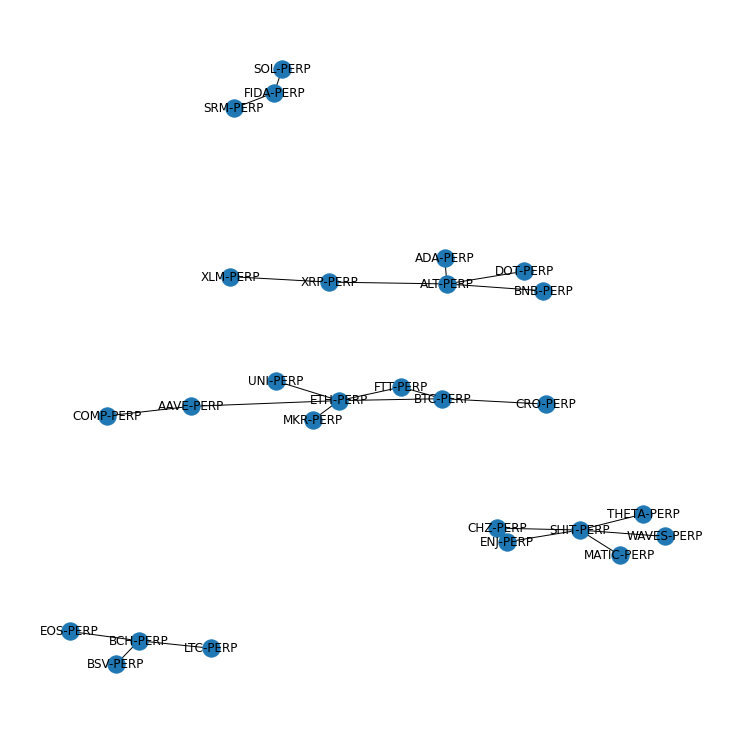

In [565]:
returns = formation_prices_df.pct_change()[1:]

edge_model = covariance.GraphicalLassoCV()
returns /= returns.std(axis=0)
edge_model.fit(returns)
p = edge_model.precision_

#prepare the matrix for network illustration
p = pd.DataFrame(p, columns=formation_prices_df.columns, index=formation_prices_df.columns)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
links=links.loc[ (abs(links['value']) > 0.1) &  (links['var1'] != links['var2']) ]

#build the graph using networkx lib
G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)
plt.figure(3, figsize=(10, 10))
nx.draw(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
plt.show()

#### Identify best pair candidates

In [566]:
# Find most mean reverting pairs
ridge = RidgeCV()
unique_pairs = []
possible_pairs = []
clusters = nx.connected_components(G)
for cluster in clusters:
    perps = list(cluster)
    for perp_a in perps:
        for perp_b in perps:
            pair = '{}/{}'.format(perp_a, perp_b)
            if perp_a != perp_b and '{}/{}'.format(perp_b, perp_a) not in unique_pairs:
                
                # regress prices
                ridge_reg = ridge.fit(formation_prices_df[perp_a].values.reshape(-1, 1), formation_prices_df[perp_b].values.reshape(-1, 1))

                # test for mean-reversion
                spread =  formation_prices_df[perp_b] - ridge_reg.coef_[0][0] * formation_prices_df[perp_a]
                half_life = calculat_half_life(spread)
                adf = adfuller(spread, 1)
                hurst = calculate_hurst(spread)

                # calculate positions ratio in dollars
                total_size = formation_prices_df[perp_b] + ridge_reg.coef_[0][0] * formation_prices_df[perp_a]
                size_ratio = formation_prices_df[perp_b] / total_size

                possible_pairs.append({
                    'pair': pair,
                    'perp_a': perp_a,
                    'perp_b': perp_b,
                    'beta_units': ridge_reg.coef_[0][0],
                    'half_life': half_life,
                    'adf_pvalue': adf[1],
                    'hurst': hurst,
                    'long_short_position_ratio': size_ratio.mean()
                })

                unique_pairs.append(pair)

possible_pairs = pd.DataFrame(possible_pairs)
top_10_pairs = possible_pairs[(possible_pairs['half_life'] > 0)].sort_values(['hurst'])[:10]
top_10_pairs

,pair,perp_a,perp_b,beta_units,half_life,adf_pvalue,hurst,long_short_position_ratio
46,BCH-PERP/BSV-PERP,BCH-PERP,BSV-PERP,0.173845,61.376024,0.000021,0.312943,0.604469
48,BSV-PERP/LTC-PERP,BSV-PERP,LTC-PERP,1.435809,58.428339,0.000034,0.324660,0.415157
66,FIDA-PERP/SOL-PERP,FIDA-PERP,SOL-PERP,21.975536,93.388534,0.057296,0.351533,0.465843
64,SRM-PERP/FIDA-PERP,SRM-PERP,FIDA-PERP,0.528776,160.367272,0.132426,0.374839,0.487453
56,CHZ-PERP/ENJ-PERP,CHZ-PERP,ENJ-PERP,4.784287,203.476729,0.053772,0.377149,0.511854
44,EOS-PERP/BSV-PERP,EOS-PERP,BSV-PERP,21.607669,93.436175,0.001578,0.392574,0.609943
65,SRM-PERP/SOL-PERP,SRM-PERP,SOL-PERP,11.446741,296.929240,0.326344,0.398354,0.457172
47,BCH-PERP/LTC-PERP,BCH-PERP,LTC-PERP,0.262477,86.773567,0.000263,0.421421,0.507817
61,THETA-PERP/ENJ-PERP,THETA-PERP,ENJ-PERP,0.219402,578.878562,0.411460,0.423758,0.515965
4,UNI-PERP/MKR-PERP,UNI-PERP,MKR-PERP,102.008440,244.005931,0.096016,0.426871,0.567140


### Backtest

In [590]:
trading_period_hours = 24*14
trading_start_date = formation_end_date
trading_end_date = trading_start_date + timedelta(hours=trading_period_hours)
trading_prices_df = pd.DataFrame(prices)[trading_start_date - timedelta(hours=trading_period_hours):trading_end_date].T.dropna().T

trading_data = {}
#for row in top_10_pairs


In [606]:
row

pair                         BCH-PERP/BSV-PERP
perp_a                                BCH-PERP
perp_b                                BSV-PERP
beta_units                            0.173845
half_life                            61.376024
adf_pvalue                            0.000021
hurst                                 0.312943
long_short_position_ratio             0.604469
Name: 46, dtype: object

<AxesSubplot:xlabel='startTime'>

<Figure size 1800x504 with 0 Axes>

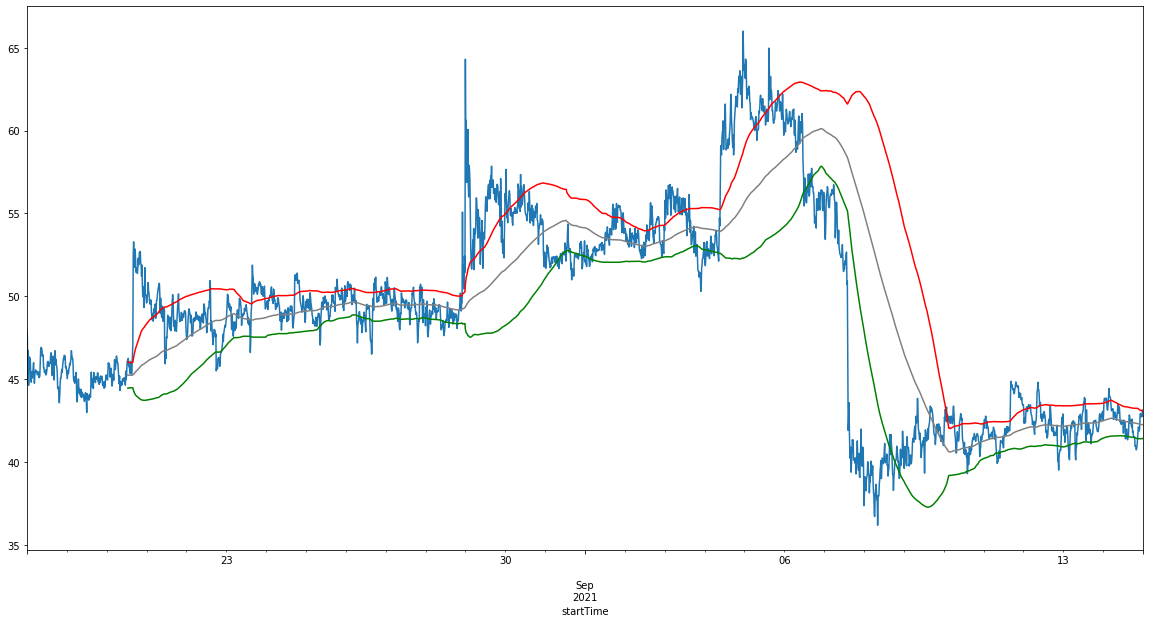

In [611]:
row = top_10_pairs.iloc[0]
formation_spread = (formation_prices_df[[row['perp_a'], row['perp_b']]] * [-row['beta_units'], 1]).sum(axis=1)
formation_mean = formation_spread.mean()
formation_std = formation_spread.std()

trading_spread = (trading_prices_df[[row['perp_a'], row['perp_b']]] * [-row['beta_units'], 1]).sum(axis=1)
rolling_mean = trading_spread.rolling(window=int(row['half_life'])*4).apply(np.mean)
rolling_std = trading_spread.rolling(window=int(row['half_life'])*4).apply(np.std)

plt.figure(figsize=(25,7))
plt.figure(figsize=(20,10))
trading_spread.plot()
rolling_mean.plot(color='grey')
(rolling_mean + rolling_std).plot(color='red')
(rolling_mean - rolling_std).plot(color='green')
